#Traditional Value Factor Algorithm

By Gil Wassermann

Strategy taken from "130/30: The New Long-Only" by Andrew Lo and Pankaj Patel

Part of the Quantopian Lecture Series:
* www.quantopian.com/lectures
* github.com/quantopian/research_public

Notebook released under the Creative Commons Attribution 4.0 License. Please do not remove this attribution.

Before the crisis of 2007, 130/30 funds were all the rage. The idea of a 130/30 fund is simple: take a long position of 130% and a short position of 30%; this combination gives a net exposure of 100% (the same as a long-only fund) as well as the added benefit of the ability to short stocks. The ability to short in a trading strategy is crucial as it allows a fund manager to capitalize on a security's poor performance, which is impossible in a traditional, long-only strategy.

This notebook, using factors outlined by Andrew Lo and Pankaj Patel in "130/30: The New Long Only", will demonstrate how to create an algorithmic 130/30 strategy. It will also highlight Quantopian's Pipeline API which is a powerful tool for developing factor trading strategies.

First, let us import all necessary libraries and functions for this algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor

#Traditional Value

In this notebook, we will develop a strategy based on the "traditional value" metrics described in the Lo/Patel whitepaper. The factors employed in this strategy designate stocks as either cheap or expensive using classic fundamental analysis. The factors that Lo/Patel used are:

* Dividend Yield
* Price to Book Value
* Price to Trailing 12-Month Sales
* Price to Trainling 12-Month Cash Flows

##Dividend Yield

Dividend yield is calculated as:

$$Dividend\;Yield = \frac{Annual\;Dividends\;per\;share}{Price\;per\;share}$$

When a company makes profit, it faces a choice. It could either reinvest those profits in the company with an eye to increase efficiency, purchase new technology, etc. or it could pay dividends to its equity holders. While reinvestment may increase a company's future share price and thereby reward investors, the most concrete way equity holders are rewarded is through dividends. An equity with a high dividend yield is particularly attractive as the quantity of dividends paid to investors represent a larger proportion of the share price itself. Now we shall create a Dividend Yield factor using the Pipeline API framework and Morningstar's list of fundamental values.

In [2]:
# Custom Factor 1 : Dividend Yield
class Div_Yield(CustomFactor):

    inputs = [morningstar.valuation_ratios.dividend_yield]
    window_length = 1

    def compute(self, today, assets, out, d_y):
        out[:] = d_y[-1]

While this factor could be calculated using other fundamental metrics, Morningstar removes the need for any calculation. It is good practice to check the list of fundamentals (https://www.quantopian.com/help/fundamentals) before creating a custom factor from scratch.

We will initialize a temporary Pipeline to get a sense of the values.

In [3]:
# create the pipeline
temp_pipe_1 = Pipeline()

# add the factor to the pipeline
temp_pipe_1.add(Div_Yield(), 'Dividend Yield')

# run the pipeline and get data for first 5 equities
run_pipeline(temp_pipe_1, start_date='2015-11-11', end_date='2015-11-11').head()

Dividend Yield
2015-11-11 00:00:00+00:00 Equity(2 [AA])              0.0132
                          Equity(21 [AAME])           0.0042
                          Equity(24 [AAPL])           0.0168
                          Equity(25 [AA_PR])          0.0435
                          Equity(31 [ABAX])           0.0079

##Price to Book Value

Price to Book Value (a.k.a Price to Book Ratio) is calculated as:

$$P/B\;Ratio = \frac{Price\;per\;share}{Net\;Asset\;Value\;per\;share}$$

Net Asset Value per share can be thought of (very roughly) as a company's total assets less its total liabilities, all divided by the number of shares outstanding.

The P/B Ratio gives a sense of a stock being either over- or undervalued. A high P/B ratio suggests that a stock's price is overvalued, and should therefore be shorted, whereas a low P/B ratio is attractive as the stock gained by purchasing the equity is hypothetically "worth more" than the price paid for it. 

We will now create a P/B Ratio custom factor and look at some of the results.

In [4]:
# Custom Factor 2 : P/B Ratio
class Price_to_Book(CustomFactor):

    inputs = [morningstar.valuation_ratios.pb_ratio]
    window_length = 1

    def compute(self, today, assets, out, pbr):
        out[:] = pbr[-1]
        
# create the Pipeline
temp_pipe_2 = Pipeline()

# add the factor to the Pipeline
temp_pipe_2.add(Price_to_Book(), 'P/B Ratio')

# run the Pipeline and get data for first 5 equities
run_pipeline(temp_pipe_2, start_date='2015-11-11', end_date='2015-11-11').head()

P/B Ratio
2015-11-11 00:00:00+00:00 Equity(2 [AA])         0.9500
                          Equity(21 [AAME])      0.9273
                          Equity(24 [AAPL])      5.6550
                          Equity(25 [AA_PR])        NaN
                          Equity(31 [ABAX])      5.3483

There are two points to make about this data series. 

Firstly, AA_PR's P/B Ratio is given as NaN by Pipeline. NaN stands for "not a number" and occurs when a value can not be fetched by Pipeline. Eventually, we will remove these NaN values from the dataset as they often lead to confusing errors when manipulating the data.

Secondly, a low P/B Ratio and a high Dividend Yield are attractive for investors, whereas a a high P/B Ratio and a low Dividend Yield are unattractive. Therefore, we will "invert" the P/B ratio by making each value negative in the factor output so that, when the data is aggregated later in the algorithm, the maxima and minima have the same underlying "meaning".

##Price to Trailing 12-Month Sales

This is calculated as a simple ratio between price per share and trailing 12-month (TTM) sales. 

TTM is a transformation rather than a metric and effectively calculates improvement or deterioration of a fundamental value from a particular quarter one year previously. For example, if one wanted to calculate today's TTM Sales for company XYZ, one would take the most recent quarter's revenue and divide it by the difference between this quarter's revenue and this quarter's revenue last year added to the revenue as given by the company's most recent fiscal year-end filing.

To calculate the exact TTM of a security is indeed possible using Pipeline; however, the code required is slow. Luckily, this value can be well approximated by the built-in Morningstar valuation ratios, which use annual sales to calculate the Price to Sales fundamental value. This slight change boosts the code's speed enormously yet has very little impact on the results of the strategy itself.

Price to TTM Sales is similar to the P/B Ratio in terms of function. The major difference in these two ratios is the fact that inclusion of TTM means that seasonal fluctuations are minimized, as previous data is used to smooth the value. In our case, annualized values accomplish this same smoothing.

Also, note that the values produced are negative; this factor requires the same inversion as the P/B Ratio.

In [5]:
# Custom Factor 3 : Price to Trailing 12 Month Sales       
class Price_to_TTM_Sales(CustomFactor):
    inputs = [morningstar.valuation_ratios.ps_ratio]
    window_length = 1
    
    def compute(self, today, assets, out, ps):
        out[:] = -ps[-1]
        
# create the pipeline
temp_pipe_3 = Pipeline()

# add the factor to the pipeline
temp_pipe_3.add(Price_to_TTM_Sales(), 'Price / TTM Sales')

# run the pipeline and get data for first 5 equities
run_pipeline(temp_pipe_3, start_date='2015-11-11', end_date='2015-11-11').head()

Price / TTM Sales
2015-11-11 00:00:00+00:00 Equity(2 [AA])                -0.4783
                          Equity(21 [AAME])             -0.5984
                          Equity(24 [AAPL])             -3.0007
                          Equity(25 [AA_PR])                NaN
                          Equity(31 [ABAX])             -5.7122

##Price to Trailing 12-Month Cashflows

This is calculated as a simple ratio between price per share and TTM free cashflow  (here using the built-in Morningstar valuation ratio as an approximaton).

This ratio serves a similar function to the previous two. A future notebook will explore the subtle differences in these metrics, but they largely serve the same purpose. Once again, low values are attractive and high values are unattractive, so the metric must be inverted.

In [6]:
# Custom Factor 4 : Price to Trailing 12 Month Cashflow
class Price_to_TTM_Cashflows(CustomFactor):
    inputs = [morningstar.valuation_ratios.pcf_ratio]
    window_length = 1
    
    def compute(self, today, assets, out, pcf):
        out[:] = -pcf[-1] 
        
# create the pipeline
temp_pipe_4 = Pipeline()

# add the factor to the pipeline
temp_pipe_4.add(Price_to_TTM_Cashflows(), 'Price / TTM Cashflows')

# run the pipeline and get data for first 5 equities
run_pipeline(temp_pipe_4, start_date='2015-11-11', end_date='2015-11-11').head()

Price / TTM Cashflows
2015-11-11 00:00:00+00:00 Equity(2 [AA])                    -5.2043
                          Equity(21 [AAME])                -32.9963
                          Equity(24 [AAPL])                 -8.6298
                          Equity(25 [AA_PR])                    NaN
                          Equity(31 [ABAX])                -43.4623

##The Full Pipeline

Now that each individual factor has been added, it is now time to get all the necessary data at once. In the algorithm, this will take place once every day.

Later in the process, we will need a factor in order to create an approximate S&P500, so we will also include another factor called SPY_proxy (SPY is an ETF that tracks the S&P500). The S&P500 is a collection of 500 of the largest companies traded on the stock market. Our interpretation of the S&P500 is a group of 500 companies with the greatest market capitalizations; however, the actual S&P500 will be slightly different as Standard and Poors, who create the index, have a more nuanced algorithm for calculation.

We will also alter our P/B Ratio factor in order to account for the inversion.

In [7]:
# This factor creates the synthetic S&P500
class SPY_proxy(CustomFactor):
    inputs = [morningstar.valuation.market_cap]
    window_length = 1
    
    def compute(self, today, assets, out, mc):
        out[:] = mc[-1]
        
# Custom Factor 2 : P/B Ratio
class Price_to_Book(CustomFactor):

    inputs = [morningstar.valuation_ratios.pb_ratio]
    window_length = 1

    def compute(self, today, assets, out, pbr):
        out[:] = -pbr[-1]
        
def Data_Pull():
    
    # create the piepline for the data pull
    Data_Pipe = Pipeline()
    
    # create SPY proxy
    Data_Pipe.add(SPY_proxy(), 'SPY Proxy')

    # Div Yield
    Data_Pipe.add(Div_Yield(), 'Dividend Yield') 
    
    # Price to Book
    Data_Pipe.add(Price_to_Book(), 'Price to Book')
    
    # Price / TTM Sales
    Data_Pipe.add(Price_to_TTM_Sales(), 'Price / TTM Sales')
    
    # Price / TTM Cashflows
    Data_Pipe.add(Price_to_TTM_Cashflows(), 'Price / TTM Cashflow')
        
    return Data_Pipe

# NB: Data pull is a function that returns a Pipeline object, so need ()
results = run_pipeline(Data_Pull(), start_date='2015-11-11', end_date='2015-11-11')
results.head()

Dividend Yield  \
2015-11-11 00:00:00+00:00 Equity(2 [AA])              0.0132   
                          Equity(21 [AAME])           0.0042   
                          Equity(24 [AAPL])           0.0168   
                          Equity(25 [AA_PR])          0.0435   
                          Equity(31 [ABAX])           0.0079   

                                              Price / TTM Cashflow  \
2015-11-11 00:00:00+00:00 Equity(2 [AA])                   -5.2043   
                          Equity(21 [AAME])               -32.9963   
                          Equity(24 [AAPL])                -8.6298   
                          Equity(25 [AA_PR])                   NaN   
                          Equity(31 [ABAX])               -43.4623   

                                              Price / TTM Sales  \
2015-11-11 00:00:00+00:00 Equity(2 [AA])                -0.4783   
                          Equity(21 [AAME])             -0.5984   
                          Equity(24 [AAPL])             -3.0007   
                          Equity(25 [AA_PR])                NaN   
                          Equity(31 [ABAX])             -5.7122   

                                              Price to Book     SPY Proxy  
2015-11-11 00:00:00+00:00 Equity(2 [AA])            -0.9500  1.190910e+10  
                          Equity(21 [AAME])         -0.9273  9.781530e+07  
                          Equity(24 [AAPL])         -5.6550  6.749500e+11  
                          Equity(25 [AA_PR])            NaN           NaN  
                          Equity(31 [ABAX])         -5.3483  1.201960e+09

##Aggregation

Now that we have all our data, we need to manipulate this in order to create a single ranking of the securities. Lo/Patel recommend the following algorithm:

* Extract the S&P500 from the set of equities and find the mean and standard deviation of each factor for this dataset (standard_frame_compute)

* Use these computed values to standardize each factor (standard_frame_compute)

* Replace values that are greater that 10 or less that -10 with 10 and -10 respectively in order to limit the effect of outliers (filter_fn)

* Sum these values for each equity and divide by the number of factors in order to give a value between -10 and 10 (composite score)

The code for this is shown below.

In [8]:
# limit effect of outliers
def filter_fn(x):
    if x <= -10:
        x = -10.0
    elif x >= 10:
        x = 10.0
    return x   

# standardize using mean and sd of S&P500
def standard_frame_compute(df):
    
    # basic clean of dataset to remove infinite values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    
    # need standardization params from synthetic S&P500
    df_SPY = df.sort(columns='SPY Proxy', ascending=False)

    # create separate dataframe for SPY
    # to store standardization values
    df_SPY = df_SPY.head(500)
    
    # get dataframes into numpy array
    df_SPY = df_SPY.as_matrix()
    
    # store index values
    index = df.index.values
    df = df.as_matrix()
    
    df_standard = np.empty(df.shape[0])
    
    
    for col_SPY, col_full in zip(df_SPY.T, df.T):
        
        # summary stats for S&P500
        mu = np.mean(col_SPY)
        sigma = np.std(col_SPY)
        col_standard = np.array(((col_full - mu) / sigma)) 

        # create vectorized function (lambda equivalent)
        fltr = np.vectorize(filter_fn)
        col_standard = (fltr(col_standard))
        
        # make range between -10 and 10
        col_standard = (col_standard / df.shape[1])
        
        # attach calculated values as new row in df_standard
        df_standard = np.vstack((df_standard, col_standard))
     
    # get rid of first entry (empty scores)
    df_standard = np.delete(df_standard,0,0)
    
    return (df_standard, index)

# Sum up and sort data
def composite_score(df, index):

    # sum up transformed data
    df_composite = df.sum(axis=0)
    
    # put into a pandas dataframe and connect numbers
    # to equities via reindexing
    df_composite = pd.Series(data=df_composite,index=index)
    
    # sort descending
    df_composite.sort(ascending=False)

    return df_composite

# compute the standardized values
results_standard, index = standard_frame_compute(results)

# aggregate the scores
ranked_scores = composite_score(results_standard, index)

# print the final rankings
ranked_scores

(2015-11-11 00:00:00+00:00, Equity(34833 [RBS]))        2.099612
(2015-11-11 00:00:00+00:00, Equity(47340 [PGN]))        2.047443
(2015-11-11 00:00:00+00:00, Equity(27993 [LINE]))       2.041414
(2015-11-11 00:00:00+00:00, Equity(44217 [CLV]))        2.038838
(2015-11-11 00:00:00+00:00, Equity(44688 [EMES]))       2.033653
(2015-11-11 00:00:00+00:00, Equity(42548 [ARP]))        2.030974
(2015-11-11 00:00:00+00:00, Equity(24 [AAPL]))          1.996974
(2015-11-11 00:00:00+00:00, Equity(7761 [UIS]))         1.989979
(2015-11-11 00:00:00+00:00, Equity(32377 [COWN]))       1.988585
(2015-11-11 00:00:00+00:00, Equity(11461 [DOM]))        1.984912
(2015-11-11 00:00:00+00:00, Equity(43513 [LNCO]))       1.972177
(2015-11-11 00:00:00+00:00, Equity(41817 [PER]))        1.936824
(2015-11-11 00:00:00+00:00, Equity(42247 [MEMP]))       1.546058
(2015-11-11 00:00:00+00:00, Equity(33159 [LGCY]))       1.477243
(2015-11-11 00:00:00+00:00, Equity(32650 [EVEP]))       1.400156
(2015-11-11 00:00:00+00:0

##Stock Choice

Now that we have ranked our securities, we need to choose a long basket and a short basket. Since we need to keep the ratio 130/30 between longs and shorts, why not have 26 longs and 6 shorts (in the algorithm we will weigh each of these equally, giving us our desired leverage and exposure).

On the graph below, we plot a histogram of the securities to get a sense of the distribution of scores. The red lines represent the cutoff points for the long and short buckets. One thing to notice is that the vast majority of equities are ranked near the middle of the histogram, whereas the tails are quite thin. This would suggest that there is something special about the securities chosen to be in these baskets, and -hopefully- these special qualities will yield positive alpha for the strategy.

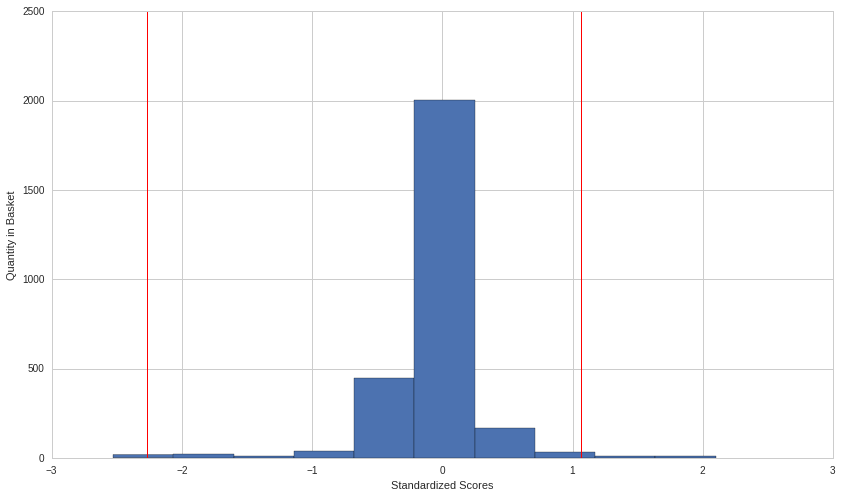

In [9]:
# create histogram of scores
ranked_scores.hist()

# make scores into list for ease of manipulation
ranked_scores_list = ranked_scores.tolist()

# add labels to axes
plt.xlabel('Standardized Scores')
plt.ylabel('Quantity in Basket')

# show long bucket
plt.axvline(x=ranked_scores_list[25], linewidth=1, color='r')

# show short bucket
plt.axvline(x=ranked_scores_list[-6], linewidth=1, color='r');

Please see the full algorithm for backtested returns!

NB: In the implementation of the algorithm, a series of filters is used in order to ensure that only tradeable stocks are included. The methodology for this filter can be found in https://www.quantopian.com/posts/pipeline-trading-universe-best-practice.

*The material on this website is provided for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation or endorsement for any security or strategy, nor does it constitute an offer to provide investment advisory or other services by Quantopian.*

*In addition, the content of the website neither constitutes investment advice nor offers any opinion with respect to the suitability of any security or any specific investment. Quantopian makes no guarantees as to accuracy or completeness of the views expressed in the website. The views are subject to change, and may have become unreliable for various reasons, including changes in market conditions or economic circumstances.*